In [2]:
import pandas as pd
import json
import glob
import tqdm
import seaborn as sns
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings("ignore")

from model_drift import settings



In [3]:
def converter(value):
    if isinstance(value, list):
        d = {str(i):vv for i, vv in enumerate(value)}
        d['all'] = value
        return d
    return value

In [4]:
dfs = []

jsonl_dir = str(settings.DATA_DIR.joinpath("red_head_h0x1hbjf"))
jsonl_files = glob.glob(f"{jsonl_dir}/*.jsonl")

for fn in tqdm.tqdm_notebook(jsonl_files):
    df = []
    with open(fn, 'r') as f:
        for line in tqdm.tqdm_notebook(f.readlines()):
            df.append({k: converter(v) for k, v in json.loads(line).items()})
    dfs.append(pd.json_normalize(df))

df = pd.concat(dfs)
print(len(df))
df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/26387 [00:00<?, ?it/s]

  0%|          | 0/26392 [00:00<?, ?it/s]

  0%|          | 0/26371 [00:00<?, ?it/s]

  0%|          | 0/26381 [00:00<?, ?it/s]

105531


index     error      mu.0  \
0  20536686640136348236148679891455886468_k6ga29.png  0.017571 -0.015945   
1  113855343774216031107737439268243531979_3k951n...  0.075379 -0.063785   
2  313723174271082992847610802266403640553-4_hhi4...  0.022395  0.015599   
3  105529804483623054726294337265160703666_6zn76a...  0.014906  0.013436   
4  102185472428957491598043403159908631419_zb8kco...  0.090683 -0.085357   

       mu.1      mu.2      mu.3      mu.4      mu.5      mu.6      mu.7  ...  \
0 -0.013659  0.054871 -0.044911  0.013308 -0.059031 -0.007672  0.103230  ...   
1 -0.228841  0.063025  0.148872  0.235560 -0.026813 -0.069000  0.387944  ...   
2 -0.055860  0.037510 -0.034584  0.016954 -0.040431 -0.001893  0.057926  ...   
3  0.003932  0.012120 -0.023085 -0.016371 -0.030419  0.010042  0.030318  ...   
4 -0.318316  0.006658  0.150164  0.198497 -0.078318 -0.067534  0.380174  ...   

   logvar.119  logvar.120  logvar.121  logvar.122  logvar.123  logvar.124  \
0   -0.018902   -1.164789    0.008582    0.021520    0.017799   -0.019862   
1   -0.040039   -0.991471   -0.095479   -0.111494   -0.040676   -0.005235   
2   -0.011489   -1.242234   -0.040924    0.019805    0.023912   -0.025186   
3   -0.012832   -1.227103   -0.034643   -0.011888    0.029016   -0.015547   
4   -0.041675   -0.965242   -0.069933   -0.127978   -0.058771   -0.005823   

   logvar.125  logvar.126  logvar.127  \
0   -0.004990    0.004133   -0.025369   
1    0.010469   -0.038714   -0.021370   
2   -0.025734    0.003396   -0.019047   
3    0.001015   -0.007563    0.007666   
4    0.061378   -0.065650   -0.046964   

                                          logvar.all  
0  [-0.015835635364055634, -0.008164092898368835,...  
1  [-0.07500659674406052, -0.04446641355752945, 0...  
2  [0.009179182350635529, 0.03407943248748779, -0...  
3  [0.019098788499832153, -0.0003490149974822998,...  
4  [-0.07593396306037903, 0.0031846128404140472, ...  

[5 rows x 260 columns]

In [7]:
from model_drift.data.padchest import PadChest

pc = PadChest.from_csv()
pc.prepare()

In [8]:
pc_df_vae = pc.df.merge(df, left_on="ImageID", right_on="index", how='inner')

In [9]:
## Include this?

pc_df_vae["Projection"].value_counts()
pc_df_vae["View"] = pc_df_vae["Projection"]
pc_df_vae.loc[pc_df_vae["View"].isin(["PA", "AP_horizontal", "AP"]), "View"] = 'Frontal'
pc_df_vae['View'].value_counts()

Frontal    72048
L          33115
COSTAL       367
UNK            1
Name: View, dtype: int64

In [10]:
cols = [c for c in list(pc_df_vae) if c.startswith("mu.") and 'all' not in c]

In [11]:
pc2 = PadChest(pc_df_vae.reset_index(drop=True),label_map=pc.label_map)
pc2.prepare()

train, val, test = pc2.split(settings.PADCHEST_SPLIT_DATES, studydate_index=True)


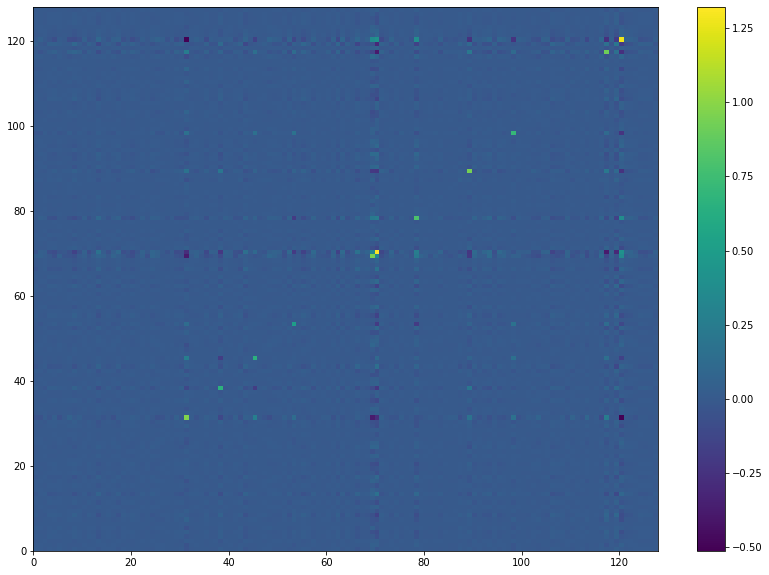

In [12]:
cov = pc_df_vae[cols].cov().values
fig, ax = plt.subplots(1,1, figsize=(14,10))
pcm = ax.pcolormesh(cov)
fig.colorbar(pcm, ax=ax)

In [13]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [14]:
corr = pc_df_vae[cols].corr()
corr = cluster_corr(corr)

fig, ax = plt.subplots(1,1, figsize=(14,10))
pcm = ax.pcolormesh(corr)
fig.colorbar(pcm, ax=ax)

NameError: name 'np' is not defined

In [ ]:
ixes = np.where(~np.eye(cov.shape[0],dtype=bool))

np.abs(cov[ixes]).max(), np.abs(cov[ixes]).min()

In [ ]:
sns.set_palette('deep')
figsize = [18, 10]
fig, ax = plt.subplots(figsize=figsize)
hue = "Projection"

_ = sns.histplot(data=pc_df_vae, x="error", hue=hue, ax=ax, kde=True)
_ = ax.set(title=f"Reconstrion Error on {len(pc_df_vae):,d} samples")

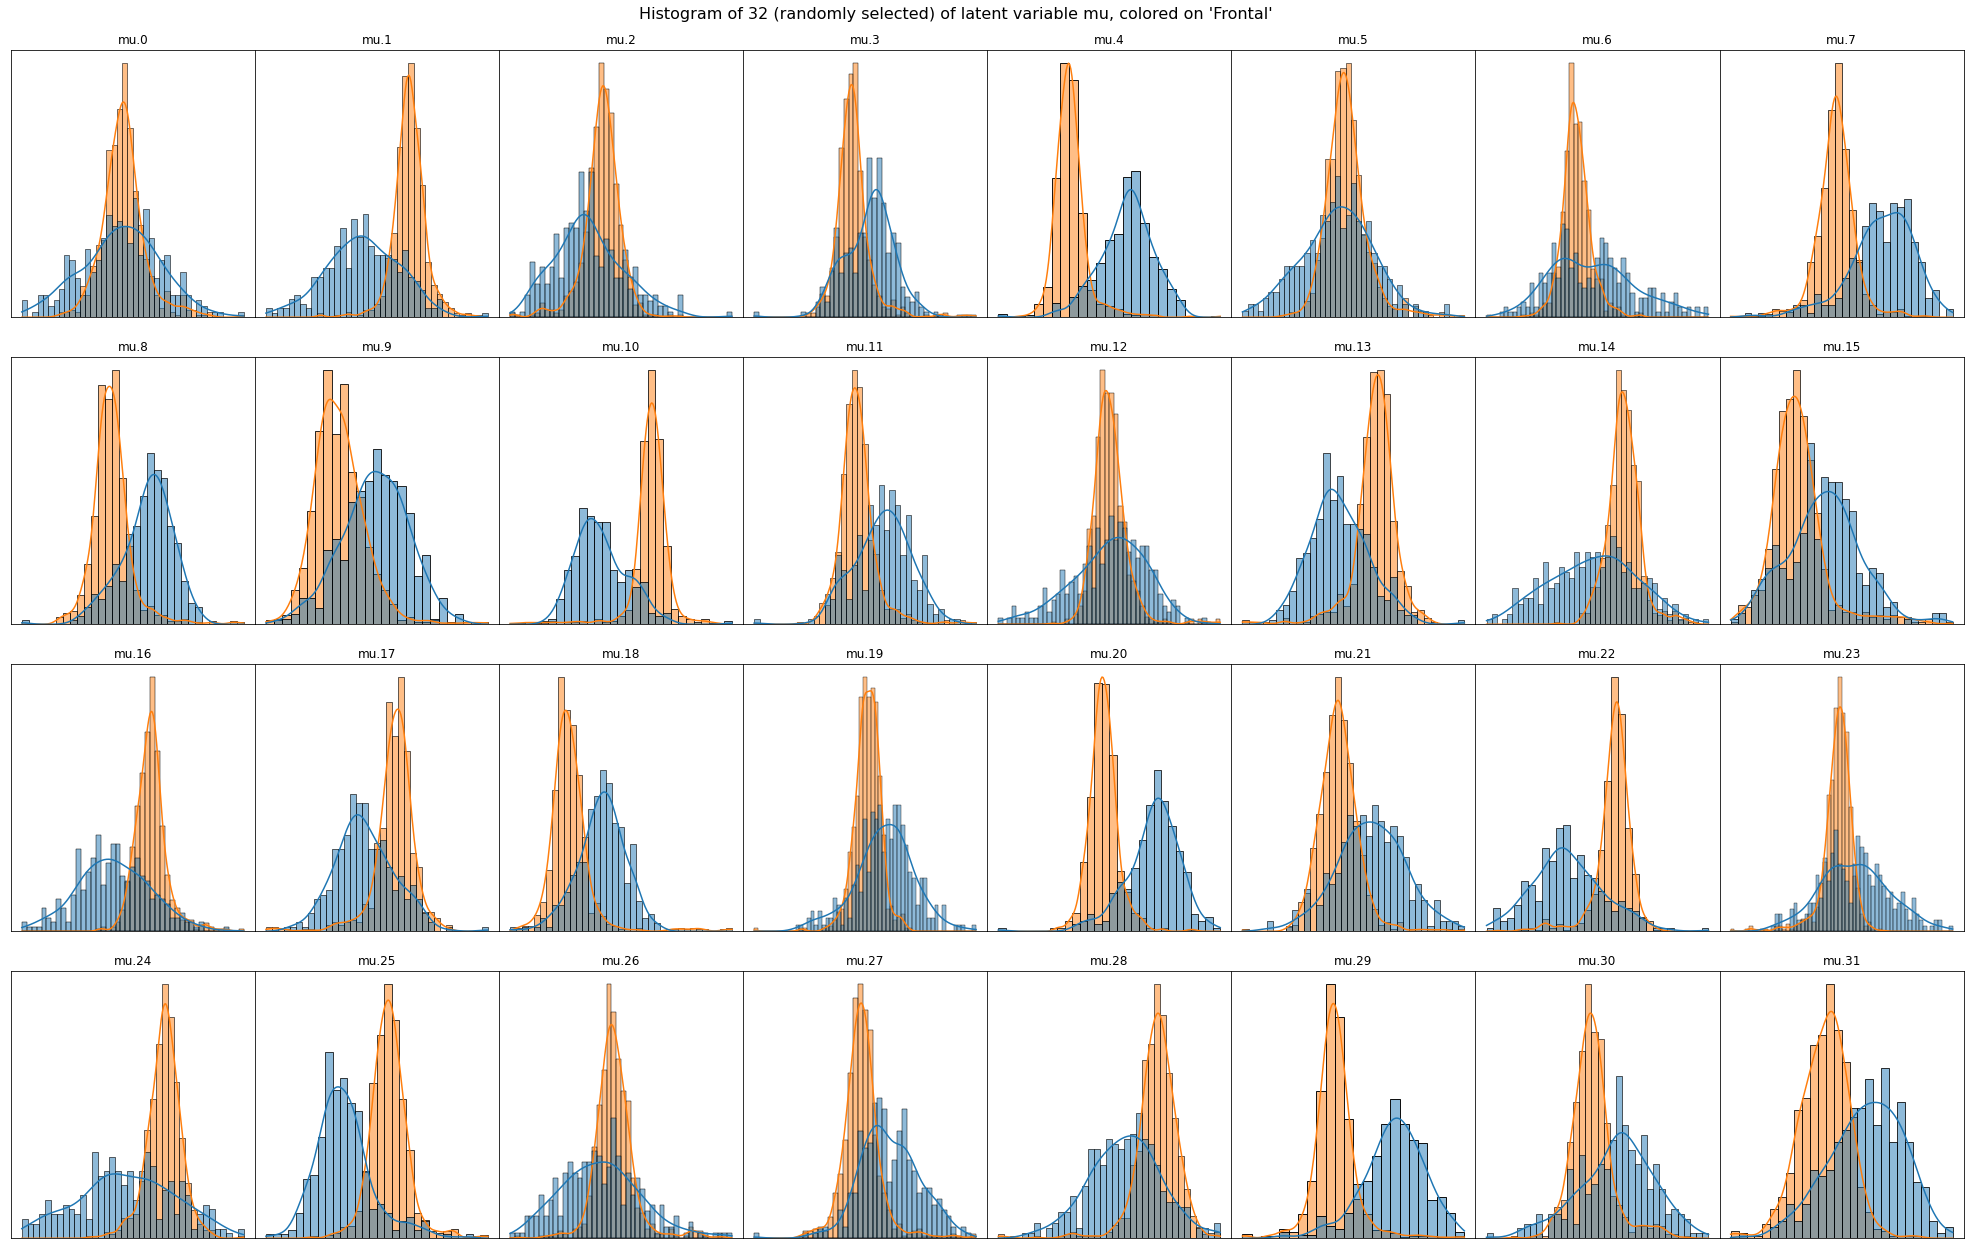

In [16]:
import random
import numpy as np
grid_size = (4, 8)
figsize = [35, 20]
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=figsize, gridspec_kw={'wspace':0, 'hspace':.15})
fig.set_facecolor('w')
axes = axes.flatten()
i_vals = list(range(np.prod(grid_size)))

random.shuffle(i_vals)

i_vals = sorted(i_vals[:len(axes)])
col = "mu"
hue = "Frontal"


xdf = pc_df_vae.sample(1000)
s = (f"Histogram of {len(i_vals)} (randomly selected) of latent variable {col}, colored on '{hue}'")
for i, i_val in enumerate(i_vals):
    xcol = f"{col}.{i_val}"
    _ = sns.histplot(data=xdf, x=xcol, hue=hue,  ax=axes[i], common_norm=False, stat='probability', kde=True)
    axes[i].set_title(xcol)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set(ylabel=None, xlabel=None)
    if 1:
        axes[i].get_legend().remove()
        continue
    # axes[i].legend(bbox_to_anchor=(-0.01, -0.2), loc='upper right', ncol=5)

fig.suptitle(s, fontsize=16)
fig.subplots_adjust(top=.95)

In [22]:
from model_drift.drift.tabular import TabularDriftCalculator
from model_drift.drift.numeric import KSDriftCalculator

dwc = TabularDriftCalculator(val.df.reset_index(drop=True))

for i in range(64):
    dwc.add_drift_stat(f'mu.{i}', KSDriftCalculator)
dwc.prepare()

dwc._metric_collections
results, data = dwc.drilldown(test.df, ["2017-01-05"])

results

2017-01-05
mu.0  ks distance          0.096013
         pval              0.000001
         critical_value    0.043964
         critical_diff     0.052050
mu.1  ks distance          0.063641
...                             ...
mu.63 ks distance          0.091471
         pval              0.000004
         critical_value    0.043964
         critical_diff     0.047507
count                    803.000000

[257 rows x 1 columns]

In [24]:
output = dwc.rolling_window_predict(test.df, stride='D')
output

100%|██████████| 1417/1417 [05:03<00:00,  4.67it/s]


count          mu.0                                         \
                              ks                                          
                   critical_diff critical_value  distance          pval   
2014-01-01     3.0     -0.060307       0.706637  0.646329  9.008026e-02   
2014-01-02    12.0     -0.047338       0.353390  0.306052  1.704990e-01   
2014-01-03    19.0     -0.056976       0.280890  0.223914  2.558073e-01   
2014-01-04    19.0     -0.056976       0.280890  0.223914  2.558073e-01   
2014-01-05    19.0     -0.056976       0.280890  0.223914  2.558073e-01   
...            ...           ...            ...       ...           ...   
2017-11-13  1026.0      0.051103       0.039082  0.090184  2.155963e-07   
2017-11-14  1058.0      0.056440       0.038513  0.094953  2.237508e-08   
2017-11-15  1101.0      0.056281       0.037788  0.094069  1.573065e-08   
2017-11-16  1087.0      0.057057       0.038019  0.095076  1.332131e-08   
2017-11-17  1068.0      0.063197       0.038340  0.101537  1.340979e-09   

                    mu.1                                                mu.10  \
                      ks                                                   ks   
           critical_diff critical_value  distance          pval critical_diff   
2014-01-01     -0.166999       0.706637  0.539637  2.473796e-01     -0.264717   
2014-01-02     -0.101992       0.353390  0.251398  3.713169e-01     -0.161471   
2014-01-03     -0.057042       0.280890  0.223848  2.561101e-01     -0.154760   
2014-01-04     -0.057042       0.280890  0.223848  2.561101e-01     -0.154760   
2014-01-05     -0.057042       0.280890  0.223848  2.561101e-01     -0.154760   
...                  ...            ...       ...           ...           ...   
2017-11-13      0.045918       0.039082  0.085000  1.292683e-06      0.031867   
2017-11-14      0.051602       0.038513  0.090115  1.378666e-07      0.037019   
2017-11-15      0.054871       0.037788  0.092659  2.740856e-08      0.037208   
2017-11-16      0.064060       0.038019  0.102080  7.495901e-10      0.048446   
2017-11-17      0.064078       0.038340  0.102418  9.276886e-10      0.049627   

            ...      mu.7                        mu.8                 \
            ...        ks                          ks                  
            ...  distance          pval critical_diff critical_value   
2014-01-01  ...  0.485345  3.683508e-01     -0.246680       0.706637   
2014-01-02  ...  0.255005  3.546321e-01     -0.086705       0.353390   
2014-01-03  ...  0.199331  3.858675e-01     -0.137013       0.280890   
2014-01-04  ...  0.199331  3.858675e-01     -0.137013       0.280890   
2014-01-05  ...  0.199331  3.858675e-01     -0.137013       0.280890   
...         ...       ...           ...           ...            ...   
2017-11-13  ...  0.113822  1.582169e-11      0.111121       0.039082   
2017-11-14  ...  0.117135  1.570084e-12      0.118632       0.038513   
2017-11-15  ...  0.117139  5.355339e-13      0.120521       0.037788   
2017-11-16  ...  0.127386  4.091254e-15      0.128974       0.038019   
2017-11-17  ...  0.131355  8.620146e-16      0.138377       0.038340   

                                            mu.9                           \
                                              ks                            
            distance          pval critical_diff critical_value  distance   
2014-01-01  0.459957  4.324110e-01     -0.191575       0.706637  0.515061   
2014-01-02  0.266685  3.038907e-01     -0.012616       0.353390  0.340774   
2014-01-03  0.143878  7.751180e-01     -0.102397       0.280890  0.178493   
2014-01-04  0.143878  7.751180e-01     -0.102397       0.280890  0.178493   
2014-01-05  0.143878  7.751180e-01     -0.102397       0.280890  0.178493   
...              ...           ...           ...            ...       ...   
2017-11-13  0.150203  8.715949e-20      0.080827       0.039082  0.119908   
2017-11-14  0.157145  2.989608e-22      0.085832

In [28]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

N = 10
fig = make_subplots (rows=2, cols=1,shared_xaxes=True, vertical_spacing = 0.05)
graph_view = output.swaplevel(0,-1, axis=1, )
g = graph_view['critical_diff']['ks']
cols_to_show = sorted(g.columns.to_flat_index())[:20]
for c in cols_to_show:
    y = g[c].rolling(N).mean()
    # fig.add_trace(go.Line(x=a.index, y=a[c], 
    # customdata=a.values,
    # hovertemplate="<br />".join([f"{c}: %{{customdata[{i}]:d}}" for i, c in enumerate(a)]),
    # name=c), row=1, col=1)

    fig.add_trace(go.Line(x=g.index, y=y, legendgroup=c,
    # customdata=output_swap[c][hcols].values,
    # hovertemplate='distance: %{customdata[0]:.3f}, p_val: %{customdata[3]:.3f}, is_drift:%{customdata[1]:d}, nobs: %{customdata[2]:d}',
    name=str(c)), 
    row=1, col=1)

g = graph_view['pval']['ks']
for c in list(g.columns.to_flat_index()):
    y = g[c].rolling(N).mean()
    # fig.add_trace(go.Line(x=a.index, y=a[c], 
    # customdata=a.values,
    # hovertemplate="<br />".join([f"{c}: %{{customdata[{i}]:d}}" for i, c in enumerate(a)]),
    # name=c), row=1, col=1)

    fig.add_trace(go.Line(x=g.index, y=y, showlegend=False,legendgroup=c,
    # customdata=output_swap[c][hcols].values,
    # hovertemplate='distance: %{customdata[0]:.3f}, p_val: %{customdata[3]:.3f}, is_drift:%{customdata[1]:d}, nobs: %{customdata[2]:d}',
    name=str(c)), 
    row=2, col=1)

fig.update_layout(title = "Activation, Critical diff and P Value")
fig.update_layout(hovermode="x unified")
fig.update_layout(height=600)
fig.show()

D:\Code\MLOpsDay2\MedImaging-ModelDriftMonitoring\.venv\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [25]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

N = 10
fig = make_subplots (rows=1, cols=1,shared_xaxes=True, vertical_spacing = 0.05)
graph_view = output.swaplevel(0,-1, axis=1, )
g = graph_view['critical_diff']['ks']
y = (g >0).mean(axis=1)
y = y.rolling(N).mean()
# fig.add_trace(go.Line(x=a.index, y=a[c], 
# customdata=a.values,
# hovertemplate="<br />".join([f"{c}: %{{customdata[{i}]:d}}" for i, c in enumerate(a)]),
# name=c), row=1, col=1)

fig.add_trace(go.Line(x=g.index, y=y, legendgroup=c,
# customdata=output_swap[c][hcols].values,
# hovertemplate='distance: %{customdata[0]:.3f}, p_val: %{customdata[3]:.3f}, is_drift:%{customdata[1]:d}, nobs: %{customdata[2]:d}',
name=str(c)), 
row=1, col=1)

# g = graph_view['pval']['ks']
# for c in list(g.columns.to_flat_index()):
#     y = g[c].rolling(N).mean()
#     # fig.add_trace(go.Line(x=a.index, y=a[c], 
#     # customdata=a.values,
#     # hovertemplate="<br />".join([f"{c}: %{{customdata[{i}]:d}}" for i, c in enumerate(a)]),
#     # name=c), row=1, col=1)

#     fig.add_trace(go.Line(x=g.index, y=y, showlegend=False,
#     # customdata=output_swap[c][hcols].values,
#     # hovertemplate='distance: %{customdata[0]:.3f}, p_val: %{customdata[3]:.3f}, is_drift:%{customdata[1]:d}, nobs: %{customdata[2]:d}',
#     name=str(c)), 
#     row=2, col=1)

fig.update_layout(title = "Average Drift Across Mu")
fig.update_layout(hovermode="x unified")
fig.update_layout(height=600)
fig.show()

D:\Code\MLOpsDay2\MedImaging-ModelDriftMonitoring\.venv\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [ ]:
from model_drift.stats import calc_p_real


ref = pc_df_vae.query("View == 'Frontal'")
target = pc_df_vae.query("View != 'Frontal'")
pvals = []
for i_val in range(128):
    xcol = f"mu.{i_val}"
    samp1 = ref[xcol].values
    samp2 = target[xcol].values
    ks, p = ks_2samp(samp1, samp2)
    if ks>0.5:
        p = 1-p
    pvals.append(ks)
    # axes[i].legend(bbox_to_anchor=(-0.01, -0.2), loc='upper right', ncol=5)

In [ ]:
plt.bar(list(range(128)), pvals)

In [ ]:
len(ref), len(target)

In [ ]:
calc_p_real(ref["error"].values, target["error"].values)

In [ ]:
from scipy.stats import ks_2samp
ks_2samp(ref["error"].values, target["error"].values)

In [ ]:
ref["error"].values[:10]

In [ ]:
target["error"].values[:10]

In [ ]:
import numpy as np
from scipy import stats
from numpy.random import randn
from numpy.random import lognormal

data_norm1 = randn(100000)
data_lognormal = lognormal(3, 1, 100000)
data_norm2 = randn(100000)

print("KS Test")
print(" norm1 vs lognormal:", ks_2samp(data_norm1, data_lognormal))
print(" norm1 vs norm2:", ks_2samp(data_norm1, data_norm2))
print(" norm1 vs norm1:", ks_2samp(data_norm1, data_norm1))
print(" norm1 vs norm2+lognormal:", ks_2samp(data_norm1, np.hstack([data_norm2, data_lognormal])))



print("T Test")
print(" norm1 vs lognormal:", stats.ttest_ind(data_norm1, data_lognormal, equal_var=False))
print(" norm1 vs norm2:", stats.ttest_ind(data_norm1, data_norm2, equal_var=False))
print(" norm1 vs norm1:", stats.ttest_ind(data_norm1, data_norm1, equal_var=False))

print(" norm1 vs norm2+lognormal:", stats.ttest_ind(data_norm1, np.hstack([data_norm2, data_lognormal]), equal_var=False))

In [ ]:
from scipy.stats import ks_2samp
ks_2samp(ref["error"].values, target["error"].values)